# Churn Prediction of Bank Users
## 蕭云雅口無言不由衷於寫出來了
### **- 陳冠穎 / 統計109 / H24051312<br />- 李艾霓 / 統計111 / H24076095**
#### 2019/4/22
* **1 競賽敘述與目標**
* **2 資料前處理**
    * 2.1 載入資料
    * 2.2 檢查缺失值
    * 2.3 檢查離群值
* **3 特徵處理與分析**
    * 3.1 移除對預測沒有幫助的變項
    * 3.2 轉換類別資料 (虛擬變數 Dummy Variable)
    * 3.3 資料分析
* **4 預測訓練模型**
    * 4.1 符合需求的衡量函式
    * 4.2 從調整參數到訓練模型
    * 4.3 將結果合併
    * 4.4 最終預測結果及輸出
* **5 預測結果分析**
    * 5.1 驗證資料得分
    * 5.2 測試資料上傳得分
    * 5.3 結果分析
* **6 感想與心得**

    

## 1. 競賽敘述與目標

　　此競賽為2019年國立成功大學統計學系李政德老師所開設的選修課程「資料科學導論」中之小組競賽，在此競賽中我們會獲得兩個資料集，分別為訓練資料(8000筆)及測試資料(2000筆)，而我們的任務則是透過這些資料去預測銀行客戶最終是否會離開銀行(即訓練資料中的"Exited"欄位)，最終將我們預測測試資料的結果上傳到課程[競賽網站](http://140.116.52.202:5566/)，即獲得預測分數。
- 分數的計算方式為: Accuracy(30%), Precision(30%), F1 Score(40%)

### 前言
　　在這份Note book之前，我們已經做過了許多的嘗試，如線性模型、SVC、KNN、決策樹、及許多由決策樹發展出的模型(Random Forest, AdaBoost, Gradient Boosting...)，而其中表現較好的還是XGBoost, CatBoost, 以及LightGBM 這三者。我們亦嘗試過將許多不同組合的分類模型Ensemble, 使用如Voting, Stacking, 及Blending等不同的手法，期望能獲得更好的結果，但結果均不如預期(甚至比原本單一分類模型效果更差)。

　　我們也曾將資料與分類模型預測會離開的機率一起列出，發現在模型預測機率約.2~.8的部分是很容易被分類錯的，亦考慮過在此範圍內的樣本可能具有不同的特徵分布(但最後證實此假設是錯誤的)。

　　因為遇到了瓶頸，我們又停下來重新思考其他可能的做法。我們分析競賽分數計算的標準，發現Precision在分數中佔了相對大的份量(除了30%之外，F1 Score有一半也受Precision的影響)，**因此，這份Note book中最主要的目的即是透過將預測的Pricision提高，藉以拉高整體分數**。

In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

# Going to try these models
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

## 2. 資料前處理
### 2.1 載入資料

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

train.head(3)

,Unnamed: 0,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,551,15806307,S2336,720,S2,Male,38,5,114051.97,2,0,1,107577.29,0
1,1,6897,15709621,S1500,682,S0,Female,54,4,62397.41,1,1,0,113088.60,1
2,2,4588,15619340,S1865,672,S0,Female,31,5,119903.67,1,1,1,132925.17,0


### 2.2 檢查缺失值

In [3]:
# Check for Null values
dataset.isnull().sum()

Age                   0
Balance               0
CreditScore           0
CustomerId            0
EstimatedSalary       0
Exited             2000
Gender                0
Geography             0
HasCrCard             0
IsActiveMember        0
NumOfProducts         0
RowNumber             0
Surname               0
Tenure                0
Unnamed: 0            0
dtype: int64

資料中沒有任何缺失值。

### 2.3 檢查離群值

In [4]:
# Outlier detection 
# 程式碼源自: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from CreditScore, Age, Balance and EstimatedSalary
Outliers_to_drop = detect_outliers(train,2,["CreditScore","Age","Balance","EstimatedSalary"])

train.loc[Outliers_to_drop] # Show the outliers rows

,Unnamed: 0,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


資料中沒有任何離群值。

## 3. 特徵處理與分析
### 3.1 移除對預測沒有幫助的變項

In [5]:
train.nunique()

Unnamed: 0         8000
RowNumber          8000
CustomerId         8000
Surname            2589
CreditScore         286
Geography             3
Gender                2
Age                  48
Tenure                6
Balance            5064
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    7998
Exited                2
dtype: int64

Unnamed: 0, RowNumber, CustomerId三者都屬於每人獨有的編號，應不具意義；而Surname我們亦假定其與個體之行為無關，可能誤導預測結果(我們也確實在先前的嘗試中得到了驗證)，因此將以上四個變數從資料中移除。

In [6]:
train.drop(['Unnamed: 0', 'RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
RowNumber = test['RowNumber']
test.drop(['Unnamed: 0', 'RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

train.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,720,S2,Male,38,5,114051.97,2,0,1,107577.29,0
1,682,S0,Female,54,4,62397.41,1,1,0,113088.60,1
2,672,S0,Female,31,5,119903.67,1,1,1,132925.17,0


### 3.2 轉換類別資料 (虛擬變數 Dummy Variable)

In [7]:
train["Gender"] = train["Gender"].map({"Male": 0, "Female":1})
test["Gender"] = test["Gender"].map({"Male": 0, "Female":1})

train = pd.get_dummies(train, columns=["Geography"],prefix="Geo")
test = pd.get_dummies(test, columns=["Geography"],prefix="Geo")

train.drop('Geo_S2',axis=1,inplace=True)
test.drop('Geo_S2',axis=1,inplace=True)

### 3.3 資料分析
#### 離開與未離開之比例

Percentage of Exited: 20.4 %


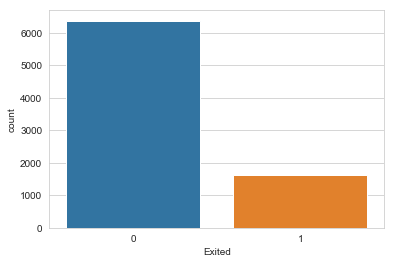

In [8]:
target = train['Exited']
sns.set_style('whitegrid')
sns.countplot(target)
print('Percentage of Exited:',train.Exited.sum()/train.Exited.count()*100,'%')

#### 變項間相關性

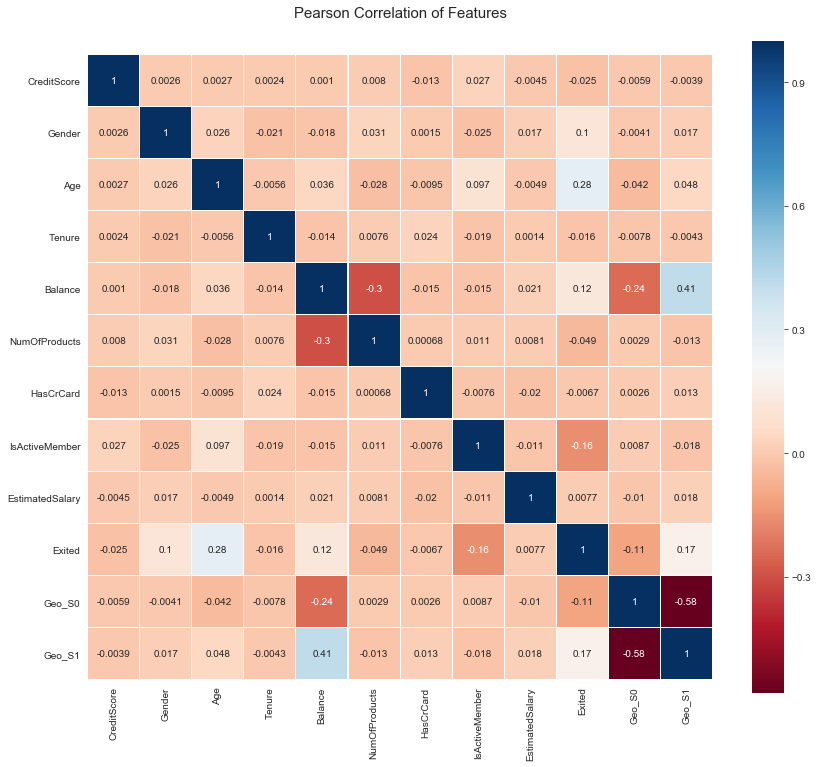

In [9]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

我們可以發現，在所有變項中僅有年齡與是否離開銀行具有較顯著的相關性。
(但並不代表其他變項是沒有用處的)

稍後我們將依相關程度作為順序一一檢視。

#### Age

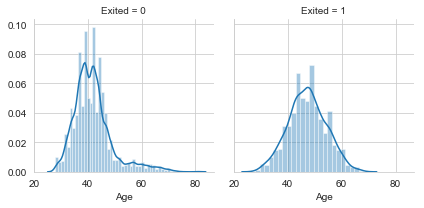

In [10]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Exited')
g = g.map(sns.distplot, "Age")

可以發現離開及未離開兩者的年齡分配具有差異，我們再將圖疊合：

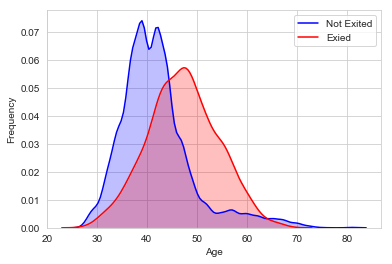

In [11]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Exited"] == 0) & (train["Age"].notnull())], color="Blue", shade = True)
g = sns.kdeplot(train["Age"][(train["Exited"] == 1) & (train["Age"].notnull())], ax =g, color="Red", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Exited","Exied"])

#### Geography

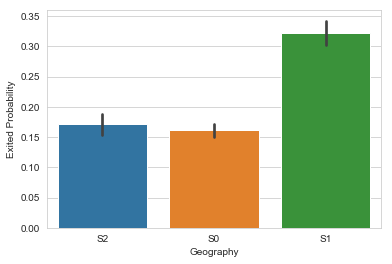

In [12]:
train2 = pd.read_csv('train.csv')
g = sns.barplot(x="Geography",y="Exited",data=train2)
g = g.set_ylabel("Exited Probability")

可以發現相較於另外兩個地區，S1地區的顧客有較大的機率會離開。

#### IsActiveMember

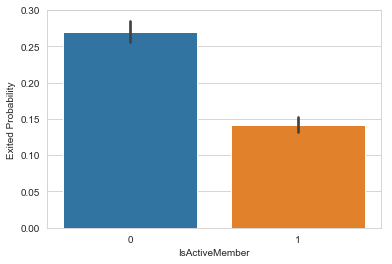

In [13]:
g = sns.barplot(x="IsActiveMember",y="Exited",data=train)
g = g.set_ylabel("Exited Probability")

不意外的，交易活動較頻繁的顧客有較低的離開可能性。

#### Balance

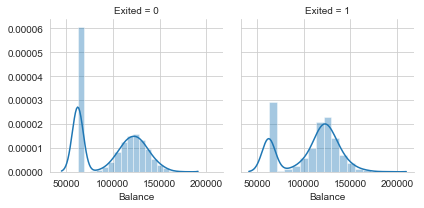

In [14]:
g = sns.FacetGrid(train, col='Exited')
g = g.map(sns.distplot, "Balance")

資料的Balance呈現一種特殊的分配情況，一樣的我們將圖疊合：

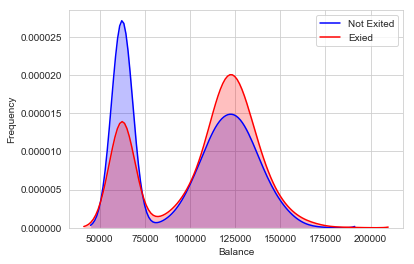

In [15]:
g = sns.kdeplot(train["Balance"][(train["Exited"] == 0) & (train["Balance"].notnull())], color="Blue", shade = True)
g = sns.kdeplot(train["Balance"][(train["Exited"] == 1) & (train["Balance"].notnull())], ax =g, color="Red", shade= True)
g.set_xlabel("Balance")
g.set_ylabel("Frequency")
g = g.legend(["Not Exited","Exied"])

#### Gender

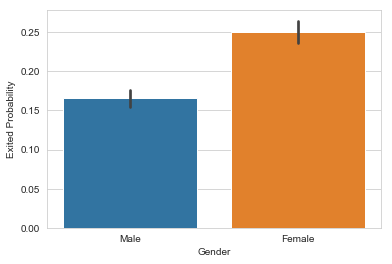

In [16]:
g = sns.barplot(x="Gender",y="Exited",data=train2)
g = g.set_ylabel("Exited Probability")

女性離開的機率較男性來得大。

#### NumOfProducts

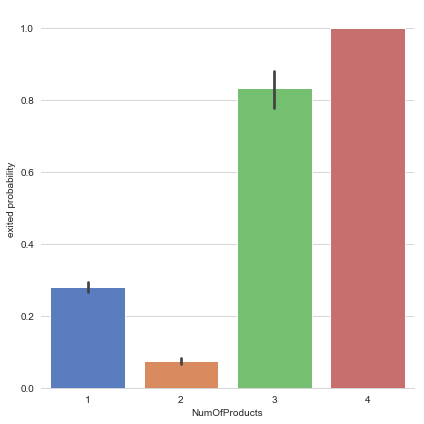

In [17]:
g = sns.factorplot(x="NumOfProducts",y="Exited",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("exited probability")

擁有不同產品數量的顧客離開的機率具有差異。需注意的是，持有1~2項產品的顧客人數是遠大於持有3~4項產品的顧客人數的：

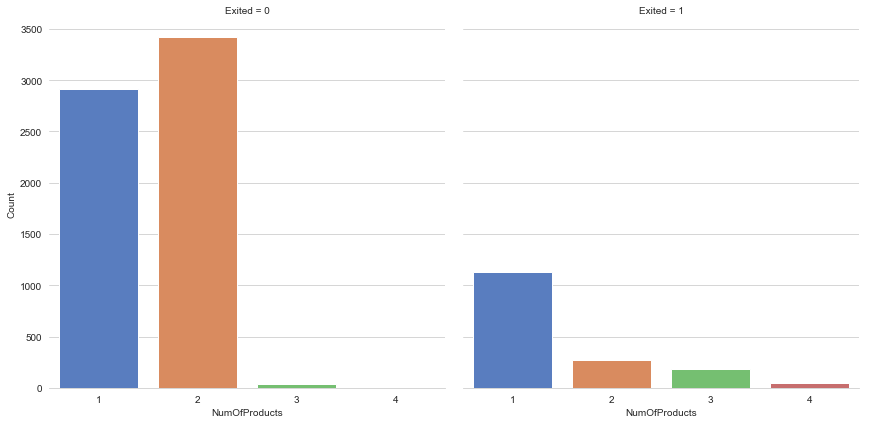

In [18]:
g = sns.factorplot("NumOfProducts", col="Exited",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

#### CreditScore

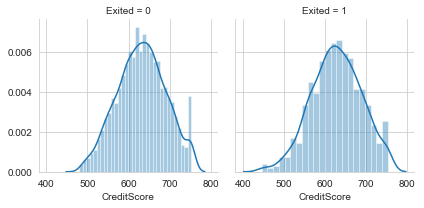

In [19]:
g = sns.FacetGrid(train, col='Exited')
g = g.map(sns.distplot, "CreditScore")

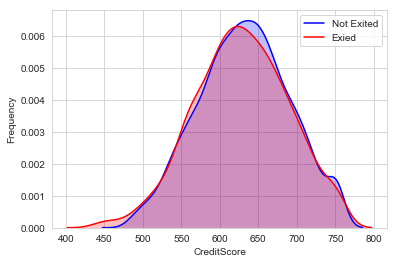

In [20]:
g = sns.kdeplot(train["CreditScore"][(train["Exited"] == 0) & (train["CreditScore"].notnull())], color="Blue", shade = True)
g = sns.kdeplot(train["CreditScore"][(train["Exited"] == 1) & (train["CreditScore"].notnull())], ax =g, color="Red", shade= True)
g.set_xlabel("CreditScore")
g.set_ylabel("Frequency")
g = g.legend(["Not Exited","Exied"])

#### Tenure

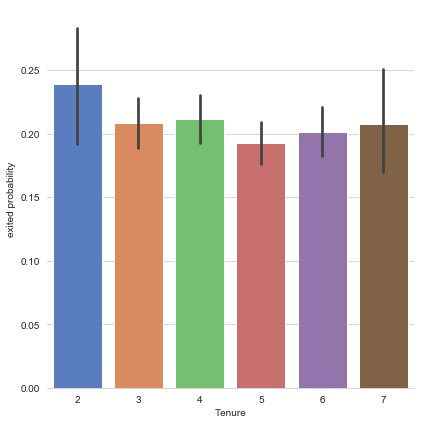

In [21]:
g = sns.factorplot(x="Tenure",y="Exited",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("exited probability")

#### EstimatedSalary

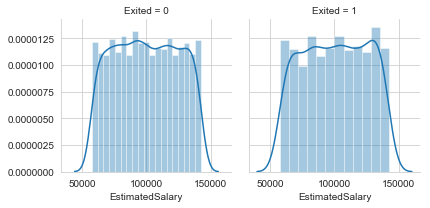

In [22]:
g = sns.FacetGrid(train, col='Exited')
g = g.map(sns.distplot, "EstimatedSalary")

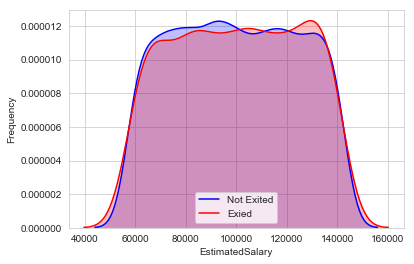

In [23]:
g = sns.kdeplot(train["EstimatedSalary"][(train["Exited"] == 0) & (train["EstimatedSalary"].notnull())], color="Blue", shade = True)
g = sns.kdeplot(train["EstimatedSalary"][(train["Exited"] == 1) & (train["EstimatedSalary"].notnull())], ax =g, color="Red", shade= True)
g.set_xlabel("EstimatedSalary")
g.set_ylabel("Frequency")
g = g.legend(["Not Exited","Exied"])

#### HasCrCard

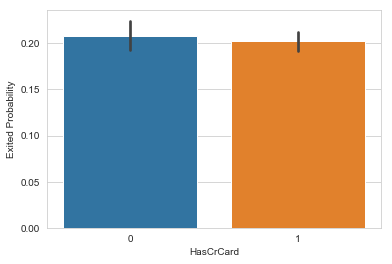

In [24]:
g = sns.barplot(x="HasCrCard",y="Exited",data=train)
g = g.set_ylabel("Exited Probability")

### 3.4 嘗試過但在這裡沒有使用的資料處理方式
#### 1. 放棄較不重要的特徵
　　雖然從上面的分析看來，後面的幾項特徵其實是看不出太大差異的，或許是可以考慮不使用，但基於先前經驗，我們認為放進去還是會對於預測有些微的幫助，因此我們保留了所有特徵。
#### 2. Standardize
　　基於我們最後所使用的所有模型皆是以決策樹為基礎，對於Scale的大小較不敏感，因此我們也省略此步驟沒有將資料進行標準化。
#### 3. PCA
　　我們有在這個模型中嘗試過，但效果不佳。

## 4. 預測訓練模型
　　理想情況下，我們若能將Precision維持在1，同時得到0.875的Accuracy，即使F1 Score將僅有0.55，最終結果分數仍會比我們原本的分數高出許多。但這樣的情況實際上卻很難實現(條件太嚴格使得很難找到足夠多的1)，因此我們勢必要放棄一定的Precision來使Recall及Accuracy能到達一定水準。我們透過不斷的嘗試，調整每個分類模型分類為1的臨界點，以及最終判定為1的所需的票數，依據train test split測試集獲得Final Score分數的高低來找出較為合適的參數設定。

### 4.1 符合需求的衡量函式
我們直接將我們想知道的衡量指標寫成一個簡單的函式，以方便使用。

In [25]:
# Function to help us evaluating our model performance
def evaluate_y_te(array,boundary=0.5):
    df = pd.DataFrame(array).iloc[:,1]
    count_wrong0 = 0
    count_wrong1 = 0
    count_true0 = 0
    count_true1 = 0
    prediction = []
    for i in range(len(y_te)):
        p = 1 if df.iat[i] > boundary else 0
        prediction.append(p)
        if p-y_te.iat[i] != 0:
            if p == 1:
                count_wrong1 += 1
            else:
                count_wrong0 += 1
        else:
            if p == 0:
                count_true0 += 1
            else:
                count_true1 += 1
    acc = 1-((count_wrong1+count_wrong0)/len(y_te))
    pre = count_true1/(count_wrong1+count_true1)
    recall = count_true1/sum(y_te)
    f1 = (2*pre*recall)/(pre+recall)
    print('Accuracy:',acc)
    print('Precision:',pre)
    print('F-score:',f1)
    print('Final:',0.4*f1+0.3*(acc+pre))
    print('Number of 1s:',count_true1+count_wrong1)
    return prediction

### 4.2 從調整參數到訓練模型
#### CatBoost
CatBoost本身就可以處理類別資料，這裡我們是直接把沒有處理過的資料丟進去。

In [26]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.drop(['Unnamed: 0', 'RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
RowNumber = test['RowNumber']
test.drop(['Unnamed: 0', 'RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

X_train = train.drop('Exited',axis=1)
y_train = train.Exited
X_test = test

random_state = 95 ## here
x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
X_train.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,720,S2,Male,38,5,114051.97,2,0,1,107577.29
1,682,S0,Female,54,4,62397.41,1,1,0,113088.60
2,672,S0,Female,31,5,119903.67,1,1,1,132925.17


這裡我們使用了兩個不同參數的CatBoost。

In [27]:
# 1
# My best classifier sofar
clf1 = CatBoostClassifier(cat_features=[1,2,7,8],ignored_features=[4],silent=True)
clf1.fit(X_train,y_train)
clf1.shrink(845,10)
P = clf1.predict_proba(X_test)
#prediction_CatBoost = evaluate_y_te(P,boundary=0.88)
prediction_CatBoost = []
for i in P:
    if i[1]>0.68:
        prediction_CatBoost.append(1)
    else:
        prediction_CatBoost.append(0)
sum(prediction_CatBoost)

181

In [28]:
# 2
clf2 = CatBoostClassifier(cat_features=[1,2,7,8],silent=True)
clf2.fit(X_train,y_train)
P = clf2.predict_proba(X_test)
#prediction_CatBoost2 = evaluate_y_te(P,boundary=0.7)
prediction_CatBoost2 = []
for i in P:
    if i[1]>0.8:
        prediction_CatBoost2.append(1)
    else:
        prediction_CatBoost2.append(0)
sum(prediction_CatBoost2)

114

### 再次處理資料 
對於CatBoost以外的分類模型，我們則要給予處理過的資料。

In [29]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.drop(['Unnamed: 0', 'RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
RowNumber = test['RowNumber']
test.drop(['Unnamed: 0', 'RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

X_train = train.drop('Exited',axis=1)
y_train = train.Exited
X_test = test

X_train["Gender"] = X_train["Gender"].map({"Male": 0, "Female":1})
X_test["Gender"] = X_test["Gender"].map({"Male": 0, "Female":1})

X_train = pd.get_dummies(X_train, columns=["Geography"],prefix="Geo")
X_test = pd.get_dummies(X_test, columns=["Geography"],prefix="Geo")

X_train.drop('Geo_S2',axis=1,inplace=True)
X_test.drop('Geo_S2',axis=1,inplace=True)

x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
X_train.head(3)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geo_S0,Geo_S1
0,720,0,38,5,114051.97,2,0,1,107577.29,0,0
1,682,1,54,4,62397.41,1,1,0,113088.60,1,0
2,672,1,31,5,119903.67,1,1,1,132925.17,1,0


#### XGB, LGBM, GB, RF
　　因模型在建構時並沒有太完整的規劃，因此排列較不整齊，以下總共使用了兩個XGBoost、兩個LightGBM、兩個GradientBoostClassifier，以及一個RandomForest。

In [30]:
# 3
clf3 = xgb.XGBClassifier()
clf3.fit(X_train,y_train)
P = clf3.predict_proba(X_test)
#prediction_XGBoost = evaluate_y_te(P,boundary=0.55)
prediction_XGBoost = []
for i in P:
    if i[1]>0.68:
        prediction_XGBoost.append(1)
    else:
        prediction_XGBoost.append(0)
sum(prediction_XGBoost)

159

In [31]:
# 4
clf4 = xgb.XGBClassifier(max_depth = 12,random_state=7,n_estimators=100,min_child_weight = 3
                          ,colsample_bytree = 0.75, subsample= 0.8)
clf4.fit(X_train,y_train)
P = clf4.predict_proba(X_test)
#prediction_XGBoost_tuned = evaluate_y_te(P,boundary=0.68)
prediction_XGBoost_tuned = []
for i in P:
    if i[1]>0.68:
        prediction_XGBoost_tuned.append(1)
    else:
        prediction_XGBoost_tuned.append(0)
sum(prediction_XGBoost_tuned)

201

In [32]:
# 5
clf5 = LGBMClassifier()
clf5.fit(X_train,y_train)
P = clf5.predict_proba(X_test)
#prediction_LGBM = evaluate_y_te(P,boundary=0.5)
prediction_LGBM = []
for i in P:
    if i[1]>0.68:
        prediction_LGBM.append(1)
    else:
        prediction_LGBM.append(0)
sum(prediction_LGBM)

194

In [33]:
# 6
clf6 = GradientBoostingClassifier()
clf6.fit(X_train,y_train)
P = clf6.predict_proba(X_test)
#prediction_GBDT = evaluate_y_te(P,boundary=0.5)
prediction_GBDT = []
for i in P:
    if i[1]>0.68:
        prediction_GBDT.append(1)
    else:
        prediction_GBDT.append(0)
sum(prediction_GBDT)

165

In [34]:
# 7
clf7 = RandomForestClassifier(n_jobs=-1,n_estimators=1000,max_depth=10,min_samples_leaf=2)
clf7.fit(X_train,y_train)
P = clf7.predict_proba(X_test)
#prediction_RF = evaluate_y_te(P,boundary=0.5)
prediction_RF = []
for i in P:
    if i[1]>0.8:
        prediction_RF.append(1)
    else:
        prediction_RF.append(0)
sum(prediction_RF)

65

In [35]:
# 8
params = {'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.1, 'n_estimators': 100,
 'num_leaves': 12, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1.2, 'reg_lambda': 1.4, 'subsample': 0.7}
clf8 = LGBMClassifier(**params)
clf8.fit(X_train,y_train)
P = clf8.predict_proba(X_test)
#prediction_LGBM = evaluate_y_te(P,boundary=0.5)
prediction_LGBM2 = []
for i in P:
    if i[1]>0.68:
        prediction_LGBM2.append(1)
    else:
        prediction_LGBM2.append(0)
sum(prediction_LGBM2)

172

In [44]:
# 9
params = {'learning_rate': 0.1, 'max_features': 0.8, 'min_samples_leaf': 1, 'n_estimators': 250, 'subsample': 0.7}
clf9 = GradientBoostingClassifier(**params) #We took off random_state
clf9.fit(X_train,y_train)
P = clf9.predict_proba(X_test)
#prediction_GBDT = evaluate_y_te(P,boundary=0.5)
prediction_GBDT2 = []
for i in P:
    if i[1]>0.68:
        prediction_GBDT2.append(1)
    else:
        prediction_GBDT2.append(0)
sum(prediction_GBDT2)

195

- 以下則是我們在建構模型時的工作區，一個用於找Classifier的參數，另一則為尋找已建構出的模型之適當分類界線：

In [37]:
# param grid to create new classifier
# Do not run this cell

mdl = GradientBoostingClassifier()
gridParams = {
    'learning_rate': [0.03,0.05,0.1,0.2],
    'n_estimators': [40,100,250,500],
    'min_samples_leaf' : [1,3],
    'subsample' : [0.7,0.75],
    'max_features' : [0.5,0.8,1]

    }

# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)
# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

{'learning_rate': 0.05, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 250, 'subsample': 0.75}
0.864625


In [38]:
# test here
# Do not run this cell

clf = clf3
clf.fit(x_tr,y_tr)
P = clf.predict_proba(x_te)
a = evaluate_y_te(P,boundary=0.68)

Accuracy: 0.85
Precision: 0.905511811023622
F-score: 0.4893617021276596
Final: 0.7223982241581505
Number of 1s: 127


### 4.3 將結果合併

In [45]:
combined_result = pd.DataFrame(prediction_CatBoost,columns=['CatBoost'])
combined_result['CatBoost2'] = prediction_CatBoost2
combined_result['XGBoost'] = prediction_XGBoost
combined_result['XGBoost2'] = prediction_XGBoost_tuned
combined_result['LGBM'] = prediction_LGBM
combined_result['LGBM2'] = prediction_LGBM2
combined_result['GBDT'] = prediction_GBDT
combined_result['GBDT2'] = prediction_GBDT2
combined_result['RandomForest'] = prediction_RF

combined_result['Sum'] = combined_result['CatBoost']+combined_result['XGBoost']+combined_result['XGBoost2']+combined_result['LGBM']+combined_result['GBDT']+combined_result['CatBoost2']+combined_result['RandomForest']+combined_result['LGBM2']+combined_result['GBDT2']
combined_result

,CatBoost,CatBoost2,XGBoost,XGBoost2,LGBM,LGBM2,GBDT,GBDT2,RandomForest,Sum
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [46]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

df = combined_result.drop('Sum',axis=1)

data = [
    go.Heatmap(
        z= df.astype(float).corr().values ,
        x=df.columns.values,
        y= df.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

其實各分類模型的預測結果相關性還是偏高的，在未來若希望再進一步提升結果，這將是一個可以著手的地方。

### 4.4 最終預測及輸出
因為個別分類模型的Precision都夠高，因此不同於一般的Voting，我們設定只要有三個Model預測為1我們就接受最終答案為1。

In [47]:
test_result = []
for i in combined_result['Sum']:
    if i >= 3:
        test_result.append(1)
    else:
        test_result.append(0)
#res = evaluate_y_te(test_result,boundary=0.5)
print(sum(test_result))

190


In [42]:
Result = pd.DataFrame(RowNumber)
Result['Exited'] = test_result

Result.to_csv('Submission.csv')

## 5. 預測結果及分析
### 5.1 驗證資料得分
(train_test_split under random_state=95)
<img src="0003.png"/>

### 5.2 測試資料上傳得分
<img src="0001.jpg"/>
最終獲得第三名。

### 5.3 結果分析
　　我們最後上傳的結果其實是比我們驗證資料得分還要高的，這可能代表我們其實還是Under Fitting的狀態，或許當我們再調整參數，還有可能再提升預測結果。又或許是這份驗證資料其實較不具代表性，也可能我們其實只是很巧合的正好Fit到了測試資料而已:)
  
## 6. 心得與感想

<img src="mdddd.jpg" width = "180" height = "180" alt="MD小穎" align=left />

### 小穎
　　能上老師的課的感覺很棒，老師又很好笑，上老師的課的時候大概都是我最認真的時候了哈哈。<br />
　　做競賽有排名這件事本身就很有壓力XD，不過這次競賽也是我第一次用python做training data，所以一開始也是摸索了很久，從找自己想方法、找模型、調整資料、調整參數，也花了不少時間，不過藉由這次競賽，自己也上網搜尋了很多別人做過的方法跟資料，上面那個網頁標籤跟老師一樣開到數不清XD。<br />

　　艾霓真的很瘋狂，無時無刻都在做，這次競賽他的貢獻也比我還多，我想我下次要更努力了哈哈。

<img src="aaa.png" width = "180" height = "180" alt="aini" align=right />

### 艾霓
　　很感謝老師這麼用心的設計了這個競賽，很好玩：)<br />
　　第一次接觸到機器學習的領域，透過這個競賽讓我能夠從頭開始探索與學習，從一個關鍵字到下一個關鍵字，隨著一次又一次的搜尋，我對這個領域的認識又更深了一些，我相信這樣的過程是重要的，也正因為是自己去挖掘，這些寶藏才更顯珍貴。在整個過程中，每當發現了一個新的關鍵字，都可以讓我興奮地睡不著覺，迫不及待想去嘗試，而我也在不斷的Try and Error當中又有了更多的思考和學習。<br />
　　在競賽結束之後，我也去回想，或許當初沒有成功的那些方法是可以再做得更好的，像是拿來Voting或是Stacking的模型可能本身就太強了，試試看換成弱一點的Model說不定會有更好的效果，或是也可以嘗試先建立一個Classifier Pool，再用Genetic Algorithm找出較適合的組合來Ensemble，在這種方法下，也能將適應函數設定成Final Score(也可以把交叉驗證也寫進去)，或許可以使我們更逼近最佳解。<br />
　　儘管競賽已經持續了幾個禮拜，但是一直到現在還是能不斷發現更多更多從來沒接觸過的東西，雖然大多數的方法都還來不及把原理搞懂，但還是期望自己之後還能在有空的時間好好的扎實的把機器學習的這些原理及算法學好。說不定哪天還能寫出一套算法那也是蠻酷炫的事情。xD

# 最後最後...附上那些我們失敗的各種過程 :D
下面完全不重要，只是我們在過程中曾經畫過的幾個有趣或有意義的圖形

<img src="3.png" align=left />
<img src="2.png" />
　　　　　　　　　　　▲ 全部預測0的SVC　　　　　　　　　　　　　　　　　　　　　　　　　　　　　▲ 沒救的MLP          

<img src="5.png" align=left />

　　　　　　　　　　　　▲ 各種Classifier使用預設參數的預測結果(10-folds)

<img src="6.png" align=left />

　　　　　　　　　　　　　　　　　　　　　　▲ 某次Voting所使用所有模型的Feature importance

<img src="4.png" />

　　　　　　　　　　　　　　　　　　　　　　　　　　　　▲ 以及結果之間的相關性


(這個Voting最後上傳Final Score只有0.7195)